In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
import distance
from subprocess import check_output
from nltk.stem import PorterStemmer
import os
from os import path


In [5]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df = df.fillna('')
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
new_df = df.sample(25000,random_state=2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [7]:
# preprocessing
def preprocess(q):
    str(q).lower().strip()
    
#   replace Special character
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
#   The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')   
    
#   Replacing some numbers with string equivalents 
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
#   Decontracting words.
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }
    q_decontracted  = []
    
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word)
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(q) == type(''):
        q = re.sub(pattern, ' ', q)
    
    
    if type(q) == type(''):
        q = porter.stem(q)
        example1 = BeautifulSoup(q)
        q = example1.get_text()
               
    
    return q

In [8]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not  b done  b  '

In [9]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [10]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))


new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,76,77,14,14,13,28,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,49,57,14,17,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,105,120,29,22,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,59,146,15,33,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas trag...,0,35,50,6,10,4,15,0.27


In [17]:
# Advanced Features
from nltk.corpus import stopwords
def fetch_token_features(q1, q2):
#     q1 = row['question1']
#     q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0] * 10
    
#     converting sentance into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
#     get non-stopwords in Q
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
#     get stopwords in Q
    q1_stop = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stop = set([word for word in q2_tokens if word in STOP_WORDS])

#     common non-stop words
    common_word_count = len(q1_words.intersection(q2_words))

#   common stop words
    common_stop_count = len(q1_stop.intersection(q2_stop))
    
#   Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stop), len(q2_stop)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stop), len(q2_stop)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
#     last word of both Q is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

#   first word of both Q is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens)- len(q2_tokens))

#   avg token length
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

# longest common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)
    
    print("token featuresss....")
    
#     merging features

    token_features = df.apply(lambda x: fetch_token_features(x['question1'],x['question2']), axis = 1)
    
    df['cwc_min'] = list(map(lambda x: x[0], token_features))
    df['cwc_max'] = list(map(lambda x: x[1], token_features))
    df['csc_min'] = list(map(lambda x: x[2], token_features))
    df['csc_max'] = list(map(lambda x: x[3], token_features))
    df['ctc_min'] = list(map(lambda x: x[4], token_features))
    df['ctc_max'] = list(map(lambda x: x[5], token_features))
    df['last_word_eq'] = list(map(lambda x: x[6], token_features))
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))
    df['abs_len_diff'] = list(map(lambda x: x[8], token_features))
    df['mean_len'] = list(map(lambda x: x[9], token_features))
    
    
    print("fuzzy featuresss....")
    
    
    df['token_set_ratio'] = df.apply(lambda x : fuzz.token_set_ratio(x['question1'],x['question2']),axis = 1)
    df['token_sort_ratio'] = df.apply(lambda x : fuzz.token_sort_ratio(x['question1'],x['question2']),axis = 1)
    df['fuzz_ratio'] = df.apply(lambda x : fuzz.QRatio(x['question1'],x['question2']),axis = 1)
    df['partial_ratio'] = df.apply(lambda x : fuzz.partial_ratio(x['question1'],x['question2']),axis = 1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    # df = pd.read_csv("train.csv")
    df = extract_features(new_df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio,longest_substr_ratio
0,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,76,77,14,14,...,0.923070,1,1,0,13.0,99,99,99,99,0.878378
1,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...,0,49,57,14,17,...,0.466664,1,1,3,13.5,74,65,69,66,0.229167


In [20]:
df.isnull().values.any()

False

In [21]:
# the most frequent occuring words
df_duplicate = df[df['is_duplicate'] == 1]
df_Nonduplicate = df[df['is_duplicate'] == 0]

p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_Nonduplicate['question1'], df_Nonduplicate['question2']]).flatten()

print("Duplicate pairs : ",len(p))
print('Non Duplicate pairs : ',len(n))

np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s' , encoding='utf-8')

Duplicate pairs :  18408
Non Duplicate pairs :  31592


In [22]:
# readinf text files and removeing stop words

textp_w = open('train_p.txt' , encoding='utf-8').read()
textn_w = open('train_n.txt', encoding='utf-8').read()

stopwords = set(STOPWORDS)
stopwords.remove('not')
stopwords.remove('no')
stopwords.remove('like')
print("Total number of words in duplicate pair Q :", len(textp_w))
print("Total number of words in non duplicate pair Q :", len(textn_w))

Total number of words in duplicate pair Q : 952349
Total number of words in non duplicate pair Q : 1970125


WordCloud for duplicate Q pairs


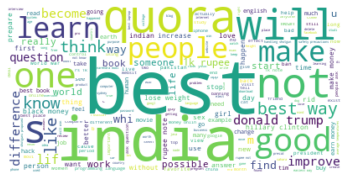

In [23]:
# Word Cloud for duplicate Q pairs 
wc = WordCloud(background_color = 'white', max_words = len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
print("WordCloud for duplicate Q pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for non duplicate Q pairs


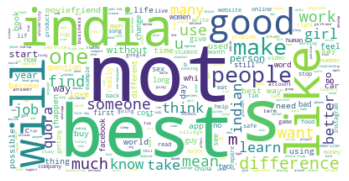

In [24]:
# Word Cloud for non duplicate Q pairs
wc = WordCloud(background_color = 'white', max_words = len(textn_w), stopwords = stopwords)
wc.generate(textn_w)
print("WordCloud for non duplicate Q pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,what is the best marketing automation tool for...,what is the best marketing automation tool for...
1,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wha...
2,i am from india and live abroad i met a guy fr...,t i e t to thapar university to thapar univers...
3,why do so many people in the u s hate the sout...,my boyfriend doesnt feel guilty when he hurts ...
4,consequences of bhopal gas tragedi,what was the reason behind the bhopal gas tragedi


In [26]:
final_df = df.drop(columns = ['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(25000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio,longest_substr_ratio
0,1,76,77,14,14,13,28,0.46,0.874989,0.874989,...,0.923070,1,1,0,13.0,99,99,99,99,0.878378
1,0,49,57,14,17,8,24,0.33,0.666644,0.499988,...,0.466664,1,1,3,13.5,74,65,69,66,0.229167
2,0,105,120,29,22,4,38,0.11,0.000000,0.000000,...,0.115384,0,0,6,23.0,43,34,26,30,0.048544
3,0,59,146,15,33,1,34,0.03,0.000000,0.000000,...,0.000000,0,0,17,21.5,30,23,28,47,0.055556
4,0,35,50,6,10,4,15,0.27,0.749981,0.599988,...,0.333330,1,0,4,7.0,69,48,55,70,0.542857


In [27]:
list(final_df.columns.values)

['is_duplicate',
 'q1_len',
 'q2_len',
 'q1_num_words',
 'q2_num_words',
 'word_common',
 'word_total',
 'word_share',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'partial_ratio',
 'longest_substr_ratio']

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
# merging text
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features = 3000)
q1_arr , q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [29]:
temp_df1 = pd.DataFrame(q1_arr , index = ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index = ques_df.index)
temp_df = pd.concat([temp_df1 , temp_df2] , axis = 1)
temp_df.shape

(25000, 6000)

In [30]:
final_df = pd.concat([final_df , temp_df], axis = 1)
print(final_df.shape)
final_df.head()

(25000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1,76,77,14,14,13,28,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
1,0,49,57,14,17,8,24,0.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
2,0,105,120,29,22,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,59,146,15,33,1,34,0.03,0.000000,0.000000,...,0,0,1,0,0,0,0,0,0,0
4,0,35,50,6,10,4,15,0.27,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7766

In [33]:
# for random forest model

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[2607,  499],
       [ 618, 1276]])

In [34]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7516

In [35]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[2533,  573],
       [ 669, 1225]])